In [1]:
import glob
import matplotlib.pyplot as plt
import cv2

In [2]:
jawis = glob.glob('words/*.png')
rumis = glob.glob('new/*.png') + glob.glob('hand/words/*.png')

In [3]:
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

def elastic_transform(image, alpha, sigma, alpha_affine, random_state=None):
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    shape_size = shape[:2]
    
    blur_size = int(4*sigma) | 1
    dx = alpha * cv2.GaussianBlur((random_state.rand(*shape) * 2 - 1),
                                  ksize=(blur_size, blur_size),
                                  sigmaX=sigma)
    dy = alpha * cv2.GaussianBlur((random_state.rand(*shape) * 2 - 1),
                                  ksize=(blur_size, blur_size),
                                  sigmaX=sigma)

    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))

    image =  map_coordinates(image, indices, order=1, mode='constant').reshape(shape)
    
    # Random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 4
    pts1 = np.float32([center_square + square_size,
                       [center_square[0]+square_size, 
                        center_square[1]-square_size],
                       center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_CONSTANT)

    return image

In [4]:
from dask import delayed
import dask

In [5]:
import numpy as np
from tqdm import tqdm

def process_jawi(i):
    jawi = jawis[i]
    img = cv2.imread(jawi)
    im = cv2.bitwise_not(img)
    im = im[:, np.min(np.where(im > 0)[1]) - 50:]
    im = im[:,:,0]
    im = elastic_transform(im, im.shape[1] * 5, im.shape[1] * 0.2, im.shape[1] * 0.001)
    return im

In [6]:
train_jawi = []
for i in range(len(jawis)):
    im = delayed(process_jawi)(i)
    train_jawi.append(im)

In [7]:
%%time

train_jawi = dask.compute(*train_jawi)

CPU times: user 40min 50s, sys: 13.4 s, total: 41min 3s
Wall time: 1min 23s


In [8]:
len(train_jawi)

31051

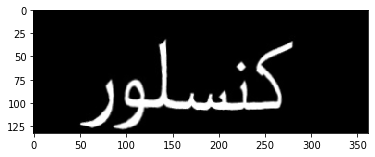

In [11]:
im = train_jawi[0]
plt.imshow(im, cmap = 'gray')

In [23]:
len(rumis)

34266

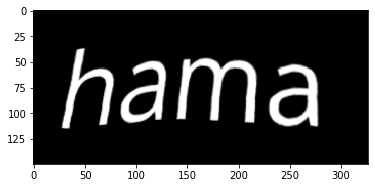

In [22]:
im = cv2.imread(rumis[0])
im = im[:,: np.max(np.where(im > 0)[1]) + 50]
im = im[:,:,0]
im = elastic_transform(im, im.shape[1] * 5, im.shape[1] * 0.2, im.shape[1] * 0.001)
plt.imshow(im, cmap = 'gray')

In [24]:
def process_rumi(i):
    rumi = rumis[i]
    im = cv2.imread(rumi)
    im = im[:,: np.max(np.where(im > 0)[1]) + 50]
    im = im[:,:,0]
    im = elastic_transform(im, im.shape[1] * 5, im.shape[1] * 0.2, im.shape[1] * 0.001)
    return im

In [27]:
train_rumi = []
for i in range(len(rumis)):
    im = delayed(process_rumi)(i)
    train_rumi.append(im)

In [28]:
%%time

train_rumi = dask.compute(*train_rumi)

CPU times: user 43min 7s, sys: 15.7 s, total: 43min 23s
Wall time: 1min 29s


In [29]:
len(train_rumi)

34266

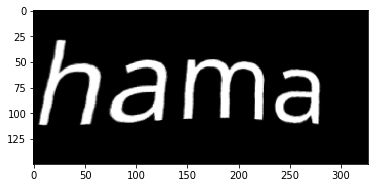

In [31]:
plt.imshow(train_rumi[0], cmap = 'gray')

In [32]:
import pickle

with open('detect-dataset.pkl', 'wb') as fopen:
    pickle.dump({'positive': train_jawi, 'negative': train_rumi}, fopen)